# BERTBQ: Taglish Complaint Classification for Philippine E-Commerce Reviews
## Using Multilingual Transformers (XLM-RoBERTa & RoBERTa-TL)

This notebook implements a complaint classification system for Taglish (Tagalog-English) reviews from Philippine e-commerce platforms.

## 1. Setup and Installation
Run this cell first to install all required packages

In [1]:
# Install required packages
!pip install -q transformers datasets accelerate scikit-learn pandas numpy matplotlib seaborn wordcloud emoji
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 13.0 MB/s eta 0:00:00


## 2. Import Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import emoji
from collections import Counter

# Hugging Face imports
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)

# Sklearn imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)
from scipy.stats import uniform, loguniform

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


## 3. Load and Explore the Dataset
We'll use the SentiTaglishProductsAndServices dataset from Hugging Face

In [3]:
# Load the dataset
try:
    dataset = load_dataset("ccosme/SentiTaglishProductsAndServices")
    print("Dataset loaded successfully!")
    print(f"Available splits: {list(dataset.keys())}")

    # Display dataset info
    if 'train' in dataset:
        print(f"\nNumber of training samples: {len(dataset['train'])}")
        print(f"Features: {dataset['train'].features}")

        # Show sample
        print("\nSample entry:")
        print(dataset['train'][0])

except Exception as e:
    print(f"Could not load dataset: {e}")
    print("Creating sample dataset for demonstration...")

    # Create sample Taglish dataset
    sample_data = {
        'text': [
            "Sobrang bagal ng delivery, 2 weeks bago dumating!",
            "The product is good pero mahal masyado for the quality",
            "Love it! Super sulit ang purchase ko",
            "Hindi gumagana yung item, sira agad",
            "Fast delivery and excellent quality!",
            "Ang pangit ng customer service nila",
            "Worth every peso, highly recommended!",
            "Scam to! Hindi tugma sa description"
        ] * 100,
        'label': [1, 1, 0, 1, 0, 1, 0, 1] * 100
    }
    dataset = {'train': sample_data}

README.md: 0.00B [00:00, ?B/s]

SentiTaglish_ProductsAndServices.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/10510 [00:00<?, ? examples/s]

Dataset loaded successfully!
Available splits: ['train']

Number of training samples: 10510
Features: {'review': Value('string'), 'sentiment': Value('int64')}

Sample entry:
{'review': 'at first gumagana cya..pero pagnalowbat cya ndi na ya magamit kahit ilang oras mo cya icharge namamatay agad..poor quality..not for recommended..', 'sentiment': 1}


## 4. Data Preprocessing
Clean and prepare the Taglish text for training

In [4]:
def clean_taglish_text(text):
    """Clean and normalize Taglish text"""
    if pd.isna(text) or text == "":
        return ""

    text = str(text)

    # Convert to lowercase (ADDED - was missing)
    text = text.lower()

    # Remove HTML tags (ADDED - was missing)
    text = re.sub(r'<[^>]+>', '', text)

    # Handle emojis
    text = emoji.demojize(text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Handle repeated characters
    text = re.sub(r'(.)\1{3,}', r'\1\1', text)

    # Handle excessive punctuation
    text = re.sub(r'[!?]{2,}', '!', text)
    text = re.sub(r'\.{2,}', '.', text)

    # Remove extra whitespaces
    text = ' '.join(text.split())

    return text.strip()


# Process the dataset
def preprocess_dataset(dataset):
    """Preprocess the entire dataset"""
    processed_data = []

    for item in dataset:
        # Find text field
        text = None
        for field in ['text', 'review', 'review_text', 'content']:
            if field in item:
                text = item[field]
                break

        # Find label field
        label = None
        for field in ['label', 'sentiment', 'sentiment_label']:
            if field in item:
                label = item[field]
                break

        if text and label is not None:
            cleaned_text = clean_taglish_text(text)

            # Convert sentiment labels (1–4) to binary complaint labels
            try:
                label = int(label)
                if label in [1, 4]:
                    binary_label = 1
                elif label in [2, 3]:
                    binary_label = 0
                else:
                    binary_label = 0
            except:
                binary_label = 1 if str(label).lower() in ['negative', 'mixed'] else 0

            processed_data.append({
                'text': cleaned_text,
                'label': binary_label
            })

    return processed_data


# Process the data
if 'train' in dataset:
    processed_data = preprocess_dataset(dataset['train'])
else:
    processed_data = preprocess_dataset(dataset)

print(f"Processed {len(processed_data)} samples")

# Check label distribution
labels = [item['label'] for item in processed_data]
print(f"\nLabel Distribution:")
print(f"  Complaints (1): {sum(labels)} ({sum(labels)/len(labels)*100:.1f}%)")
print(f"  Non-complaints (0): {len(labels)-sum(labels)} ({(len(labels)-sum(labels))/len(labels)*100:.1f}%)")

Processed 10510 samples

Label Distribution:
  Complaints (1): 6805 (64.7%)
  Non-complaints (0): 3705 (35.3%)


## 5. Split the Dataset
Create train, validation, and test sets with stratification

In [5]:
# Convert to DataFrame
df = pd.DataFrame(processed_data)

# Split data: 70% train, 15% validation, 15% test
train_val_df, test_df = train_test_split(
    df, test_size=0.15, stratify=df['label'], random_state=RANDOM_SEED
)

train_df, val_df = train_test_split(
    train_val_df, test_size=0.176, stratify=train_val_df['label'], random_state=RANDOM_SEED
)  # 0.176 ≈ 15% of original

print(f"Dataset splits:")
print(f"  Train: {len(train_df)} samples")
print(f"  Validation: {len(val_df)} samples")
print(f"  Test: {len(test_df)} samples")

# Verify stratification
for name, split_df in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
    complaint_ratio = split_df['label'].mean()
    print(f"  {name} complaint ratio: {complaint_ratio:.2%}")

Dataset splits:
  Train: 7360 samples
  Validation: 1573 samples
  Test: 1577 samples
  Train complaint ratio: 64.76%
  Val complaint ratio: 64.72%
  Test complaint ratio: 64.74%


## 6. Baseline Model: TF-IDF + Logistic Regression
Establish baseline performance with Confusion Matrix and Classification Report

Training Baseline Model (TF-IDF + Logistic Regression)
TF-IDF features shape: (7360, 5000)

Baseline Validation Results:
  Accuracy: 0.8970
  Precision: 0.8898
  Recall: 0.8831
  F1-Score: 0.8863

Baseline Test Results:
  accuracy: 0.8935
  precision: 0.8833
  recall: 0.8833
  f1: 0.8833

CONFUSION MATRIX (Baseline)
[[472  84]
 [ 84 937]]


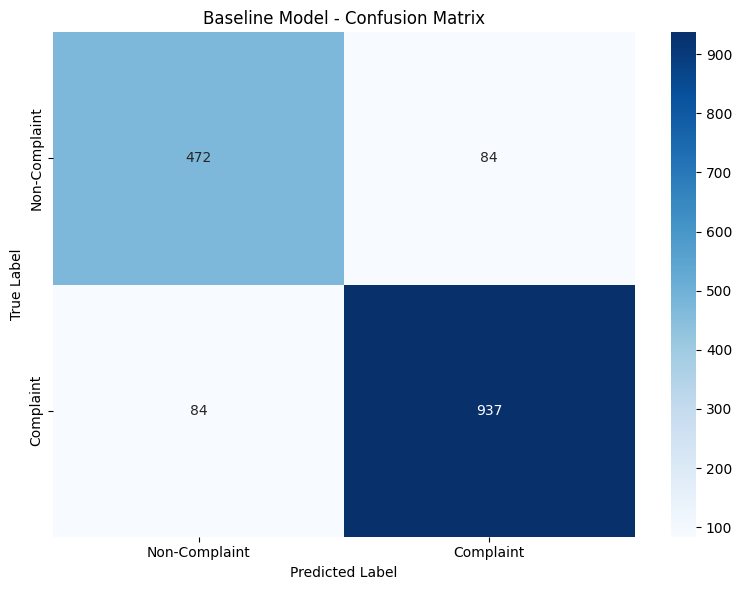


CLASSIFICATION REPORT (Baseline)
               precision    recall  f1-score   support

Non-Complaint       0.85      0.85      0.85       556
    Complaint       0.92      0.92      0.92      1021

     accuracy                           0.89      1577
    macro avg       0.88      0.88      0.88      1577
 weighted avg       0.89      0.89      0.89      1577



In [6]:
print("Training Baseline Model (TF-IDF + Logistic Regression)")
print("="*50)

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.95
)

# Vectorize text
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['text'])
X_val_tfidf = tfidf_vectorizer.transform(val_df['text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['text'])

print(f"TF-IDF features shape: {X_train_tfidf.shape}")

# Train Logistic Regression
lr_classifier = LogisticRegression(
    random_state=RANDOM_SEED,
    max_iter=1000,
    class_weight='balanced'
)

lr_classifier.fit(X_train_tfidf, train_df['label'])

# Evaluate on validation set
val_pred_baseline = lr_classifier.predict(X_val_tfidf)
val_acc = accuracy_score(val_df['label'], val_pred_baseline)
precision, recall, f1, _ = precision_recall_fscore_support(
    val_df['label'], val_pred_baseline, average='macro'
)

print(f"\nBaseline Validation Results:")
print(f"  Accuracy: {val_acc:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

# Test set evaluation
test_pred_baseline = lr_classifier.predict(X_test_tfidf)
baseline_test_metrics = {
    'accuracy': accuracy_score(test_df['label'], test_pred_baseline),
    'precision': precision_recall_fscore_support(test_df['label'], test_pred_baseline, average='macro')[0],
    'recall': precision_recall_fscore_support(test_df['label'], test_pred_baseline, average='macro')[1],
    'f1': precision_recall_fscore_support(test_df['label'], test_pred_baseline, average='macro')[2]
}

print(f"\nBaseline Test Results:")
for metric, value in baseline_test_metrics.items():
    print(f"  {metric}: {value:.4f}")

# ADDED: Confusion Matrix (was missing)
print("\n" + "="*50)
print("CONFUSION MATRIX (Baseline)")
print("="*50)
cm_baseline = confusion_matrix(test_df['label'], test_pred_baseline)
print(cm_baseline)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Complaint', 'Complaint'],
            yticklabels=['Non-Complaint', 'Complaint'])
plt.title('Baseline Model - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ADDED: Classification Report (was missing)
print("\n" + "="*50)
print("CLASSIFICATION REPORT (Baseline)")
print("="*50)
print(classification_report(test_df['label'], test_pred_baseline,
                            target_names=['Non-Complaint', 'Complaint']))

## 7. Hyperparameter Tuning with RandomizedSearchCV
Optimize baseline model using random search

In [7]:
print("Hyperparameter Tuning with RandomizedSearchCV")
print("="*50)

# Define parameter distributions for RandomizedSearchCV
param_distributions = {
    'C': loguniform(1e-3, 1e2),  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga'],  # Solvers that support both l1 and l2
    'max_iter': [500, 1000, 2000],
    'class_weight': ['balanced', None]
}

# Initialize base model
lr_base = LogisticRegression(random_state=RANDOM_SEED)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lr_base,
    param_distributions=param_distributions,
    n_iter=50,  # Number of random combinations to try
    cv=5,  # 5-fold cross-validation
    scoring='f1_macro',
    n_jobs=-1,
    random_state=RANDOM_SEED,
    verbose=1
)

# Fit on training data
print("\nRunning RandomizedSearchCV...")
random_search.fit(X_train_tfidf, train_df['label'])

# Best parameters
print("\nBest Parameters Found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest CV F1-Score: {random_search.best_score_:.4f}")

# Evaluate tuned model on test set
best_lr = random_search.best_estimator_
test_pred_tuned = best_lr.predict(X_test_tfidf)

tuned_test_metrics = {
    'accuracy': accuracy_score(test_df['label'], test_pred_tuned),
    'precision': precision_recall_fscore_support(test_df['label'], test_pred_tuned, average='macro')[0],
    'recall': precision_recall_fscore_support(test_df['label'], test_pred_tuned, average='macro')[1],
    'f1': precision_recall_fscore_support(test_df['label'], test_pred_tuned, average='macro')[2]
}

print("\nTuned Baseline Test Results:")
for metric, value in tuned_test_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Compare with original baseline
print("\nImprovement over Original Baseline:")
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    improvement = ((tuned_test_metrics[metric] - baseline_test_metrics[metric]) / baseline_test_metrics[metric]) * 100
    print(f"  {metric}: {improvement:+.2f}%")

# Confusion Matrix for tuned model
print("\n" + "="*50)
print("CONFUSION MATRIX (Tuned Baseline)")
print("="*50)
cm_tuned = confusion_matrix(test_df['label'], test_pred_tuned)
print(cm_tuned)

# Classification Report for tuned model
print("\n" + "="*50)
print("CLASSIFICATION REPORT (Tuned Baseline)")
print("="*50)
print(classification_report(test_df['label'], test_pred_tuned,
                            target_names=['Non-Complaint', 'Complaint']))

Hyperparameter Tuning with RandomizedSearchCV

Running RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Parameters Found:
  C: 3.4702669886504163
  class_weight: None
  max_iter: 500
  penalty: l2
  solver: saga

Best CV F1-Score: 0.8814

Tuned Baseline Test Results:
  accuracy: 0.9004
  precision: 0.8986
  recall: 0.8809
  f1: 0.8886

Improvement over Original Baseline:
  accuracy: +0.78%
  precision: +1.73%
  recall: -0.27%
  f1: +0.60%

CONFUSION MATRIX (Tuned Baseline)
[[453 103]
 [ 54 967]]

CLASSIFICATION REPORT (Tuned Baseline)
               precision    recall  f1-score   support

Non-Complaint       0.89      0.81      0.85       556
    Complaint       0.90      0.95      0.92      1021

     accuracy                           0.90      1577
    macro avg       0.90      0.88      0.89      1577
 weighted avg       0.90      0.90      0.90      1577



## 8. Feature Analysis
Identify important words for classification

In [8]:
# Get feature importance from the best model
feature_names = tfidf_vectorizer.get_feature_names_out()
coef = best_lr.coef_[0]

# Top complaint indicators
top_complaint_idx = coef.argsort()[-15:][::-1]
top_complaint_features = [(feature_names[i], coef[i]) for i in top_complaint_idx]

print("Top 15 Complaint Indicators:")
for feature, score in top_complaint_features:
    print(f"  {feature}: {score:.3f}")

# Top non-complaint indicators
top_non_complaint_idx = coef.argsort()[:15]
top_non_complaint_features = [(feature_names[i], coef[i]) for i in top_non_complaint_idx]

print("\nTop 15 Non-Complaint Indicators:")
for feature, score in top_non_complaint_features:
    print(f"  {feature}: {score:.3f}")

Top 15 Complaint Indicators:
  kaso: 10.890
  not: 8.331
  pero: 6.354
  disappointed: 5.740
  but: 4.701
  lang: 4.312
  sira: 4.152
  hindi: 4.100
  di: 4.072
  wrong: 3.906
  sayang: 3.746
  yung: 3.692
  poor: 3.640
  tapos: 3.448
  mali: 3.426

Top 15 Non-Complaint Indicators:
  ganda: -6.433
  love: -4.475
  thank: -4.274
  super: -4.121
  safe: -3.885
  ulit: -3.667
  salamat: -3.661
  good: -3.508
  maganda: -3.395
  excellent: -3.331
  nice: -3.221
  sulit: -3.070
  thankyou: -3.041
  gandaaa: -2.959
  sarap: -2.876


## 9. Transformer Model Setup
Prepare functions for training transformer models

In [9]:
def compute_metrics(eval_pred):
    """Compute metrics for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='macro'
    )

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def prepare_dataset_for_transformer(df, tokenizer, max_length=256):
    """Prepare dataset for transformer training"""
    def tokenize_function(examples):
        return tokenizer(
            examples['text'],
            padding='max_length',
            truncation=True,
            max_length=max_length
        )

    dataset = Dataset.from_pandas(df[['text', 'label']].reset_index(drop=True))
    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    tokenized_dataset = tokenized_dataset.rename_column('label', 'labels')
    tokenized_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

    return tokenized_dataset

## 10. Train XLM-RoBERTa Model
Fine-tune multilingual transformer with correct hyperparameters

In [10]:
print("Training XLM-RoBERTa Model")
print("="*50)

# Load model and tokenizer
model_name = "xlm-roberta-base"
xlm_tokenizer = AutoTokenizer.from_pretrained(model_name)
xlm_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
).to(device)

# Prepare datasets
train_dataset = prepare_dataset_for_transformer(train_df, xlm_tokenizer)
val_dataset = prepare_dataset_for_transformer(val_df, xlm_tokenizer)

# Training arguments (CORRECTED - using warmup_ratio and explicit learning_rate)
training_args = TrainingArguments(
    output_dir="./results/xlm-roberta",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_ratio=0.1,  # CORRECTED: was warmup_steps=200
    learning_rate=2e-5,  # ADDED: explicit learning rate
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",  # CORRECTED: explicitly set
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
    seed=RANDOM_SEED
)

# Create trainer
xlm_trainer = Trainer(
    model=xlm_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=xlm_tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train
print("Starting training...")
xlm_trainer.train()

# Evaluate
xlm_val_results = xlm_trainer.evaluate()
print("\nXLM-RoBERTa Validation Results:")
for key, value in xlm_val_results.items():
    if not key.startswith('eval_'):
        continue
    metric_name = key.replace('eval_', '')
    print(f"  {metric_name}: {value:.4f}")

Training XLM-RoBERTa Model


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7360 [00:00<?, ? examples/s]

Map:   0%|          | 0/1573 [00:00<?, ? examples/s]

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.327700,0.338766,0.891291,0.881768,0.879545,0.880634
2,0.312600,0.424952,0.908455,0.914235,0.884201,0.896277
3,0.173300,0.400775,0.914812,0.912859,0.898947,0.905195



XLM-RoBERTa Validation Results:
  loss: 0.4008
  accuracy: 0.9148
  precision: 0.9129
  recall: 0.8989
  f1: 0.9052
  runtime: 5.6201
  samples_per_second: 279.8880
  steps_per_second: 35.0530


## 11. Train RoBERTa-TL (Filipino) Model
Fine-tune Filipino-specific transformer with correct hyperparameters

In [11]:
print("Training RoBERTa-TL (Filipino) Model")
print("="*50)

# Load model and tokenizer
model_name_tl = "jcblaise/roberta-tagalog-base"
tl_tokenizer = AutoTokenizer.from_pretrained(model_name_tl)
tl_model = AutoModelForSequenceClassification.from_pretrained(
    model_name_tl,
    num_labels=2
).to(device)

# Add padding token if needed
if tl_tokenizer.pad_token is None:
    tl_tokenizer.pad_token = tl_tokenizer.eos_token

# Prepare datasets
train_dataset_tl = prepare_dataset_for_transformer(train_df, tl_tokenizer)
val_dataset_tl = prepare_dataset_for_transformer(val_df, tl_tokenizer)

# Training arguments (CORRECTED - using warmup_ratio and explicit learning_rate)
training_args_tl = TrainingArguments(
    output_dir="./results/roberta-tl",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_ratio=0.1,  # CORRECTED: was warmup_steps=200
    learning_rate=2e-5,  # ADDED: explicit learning rate
    weight_decay=0.01,
    gradient_accumulation_steps=1,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",  # CORRECTED: explicitly set
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
    seed=RANDOM_SEED
)

# Create trainer
tl_trainer = Trainer(
    model=tl_model,
    args=training_args_tl,
    train_dataset=train_dataset_tl,
    eval_dataset=val_dataset_tl,
    tokenizer=tl_tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train
print("Starting training...")
tl_trainer.train()

# Evaluate
tl_val_results = tl_trainer.evaluate()
print("\nRoBERTa-TL Validation Results:")
for key, value in tl_val_results.items():
    if not key.startswith('eval_'):
        continue
    metric_name = key.replace('eval_', '')
    print(f"  {metric_name}: {value:.4f}")

Training RoBERTa-TL (Filipino) Model


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/715 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/437M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at jcblaise/roberta-tagalog-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7360 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Map:   0%|          | 0/1573 [00:00<?, ? examples/s]

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.305000,0.289516,0.895741,0.895961,0.873149,0.882671
2,0.202600,0.435114,0.898284,0.902735,0.872655,0.884638
3,0.065900,0.473984,0.907819,0.907536,0.888627,0.896800



RoBERTa-TL Validation Results:
  loss: 0.4740
  accuracy: 0.9078
  precision: 0.9075
  recall: 0.8886
  f1: 0.8968
  runtime: 5.7927
  samples_per_second: 271.5490
  steps_per_second: 34.0080


## 12. Evaluate All Models on Test Set
Compare performance of all models

In [12]:
# Function to evaluate transformer on test set
def evaluate_transformer_on_test(trainer, test_df, tokenizer, model_name):
    """Evaluate transformer model on test set"""
    test_dataset = prepare_dataset_for_transformer(test_df, tokenizer)
    predictions = trainer.predict(test_dataset)

    y_pred = np.argmax(predictions.predictions, axis=1)
    y_true = test_df['label'].values

    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_recall_fscore_support(y_true, y_pred, average='macro')[0],
        'recall': precision_recall_fscore_support(y_true, y_pred, average='macro')[1],
        'f1': precision_recall_fscore_support(y_true, y_pred, average='macro')[2]
    }

    print(f"\n{model_name} Test Results:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

    return metrics, y_pred

# Evaluate all transformer models
xlm_test_metrics, xlm_test_pred = evaluate_transformer_on_test(
    xlm_trainer, test_df, xlm_tokenizer, "XLM-RoBERTa"
)

tl_test_metrics, tl_test_pred = evaluate_transformer_on_test(
    tl_trainer, test_df, tl_tokenizer, "RoBERTa-TL"
)

Map:   0%|          | 0/1577 [00:00<?, ? examples/s]


XLM-RoBERTa Test Results:
  accuracy: 0.9131
  precision: 0.9052
  recall: 0.9042
  f1: 0.9047


Map:   0%|          | 0/1577 [00:00<?, ? examples/s]


RoBERTa-TL Test Results:
  accuracy: 0.9144
  precision: 0.9100
  recall: 0.9011
  f1: 0.9052


## 13. Model Comparison and Visualization


MODEL COMPARISON SUMMARY
               Model  accuracy  precision  recall     f1
Baseline (TF-IDF+LR)    0.8935     0.8833  0.8833 0.8833
      Tuned Baseline    0.9004     0.8986  0.8809 0.8886
         XLM-RoBERTa    0.9131     0.9052  0.9042 0.9047
          RoBERTa-TL    0.9144     0.9100  0.9011 0.9052

IMPROVEMENT OVER BASELINE (F1-Score)
Tuned Baseline: +0.6%
XLM-RoBERTa: +2.4%
RoBERTa-TL: +2.5%


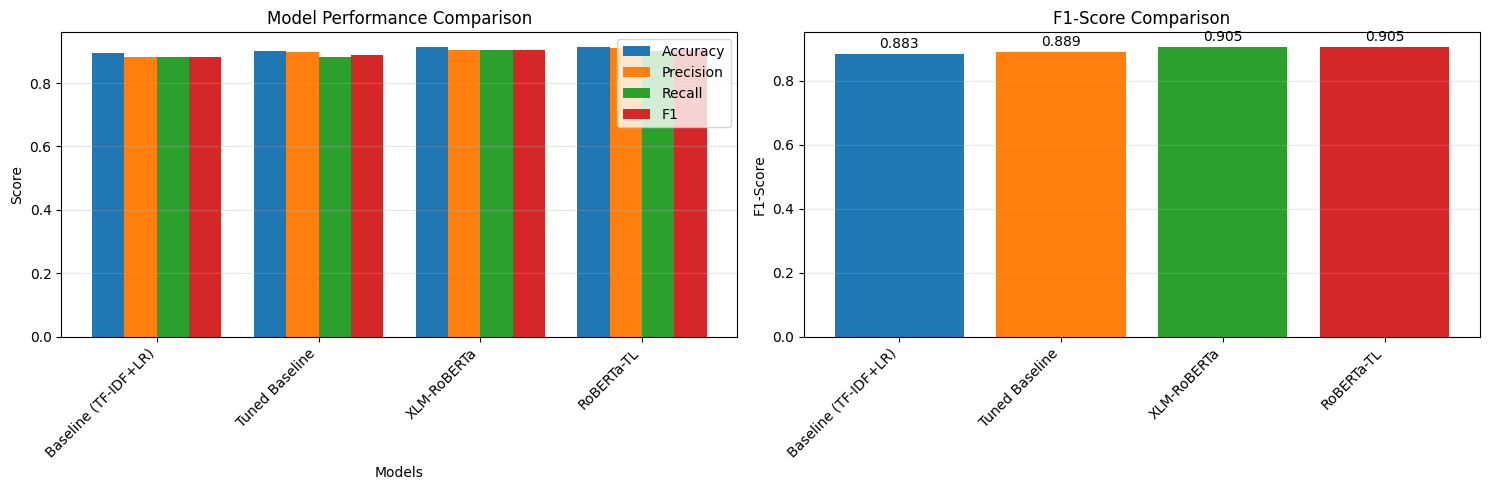

In [13]:
# Create comparison DataFrame
comparison_data = [
    {'Model': 'Baseline (TF-IDF+LR)', **baseline_test_metrics},
    {'Model': 'Tuned Baseline', **tuned_test_metrics},
    {'Model': 'XLM-RoBERTa', **xlm_test_metrics},
    {'Model': 'RoBERTa-TL', **tl_test_metrics}
]

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(comparison_df.to_string(index=False))

# Calculate improvement over baseline
baseline_f1 = baseline_test_metrics['f1']
print("\n" + "="*60)
print("IMPROVEMENT OVER BASELINE (F1-Score)")
print("="*60)
for _, row in comparison_df.iterrows():
    if row['Model'] != 'Baseline (TF-IDF+LR)':
        improvement = ((row['f1'] - baseline_f1) / baseline_f1) * 100
        print(f"{row['Model']}: {improvement:+.1f}%")

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Metrics comparison
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
x = np.arange(len(comparison_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    offset = (i - 1.5) * width
    axes[0].bar(x + offset, comparison_df[metric], width, label=metric.capitalize())

axes[0].set_xlabel('Models')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: F1-Score comparison
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = axes[1].bar(comparison_df['Model'], comparison_df['f1'], color=colors)
axes[1].set_ylabel('F1-Score')
axes[1].set_title('F1-Score Comparison')
axes[1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, comparison_df['f1']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{val:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 14. Error Analysis
Analyze incorrect predictions made by the best model on the test set

ERROR ANALYSIS

Analyzing errors from best model: RoBERTa-TL

Total test samples: 1577
Correctly classified: 1442
Misclassified: 135 (8.6%)

Error Breakdown:
  False Positives (predicted Complaint, actually Non-Complaint): 80
  False Negatives (predicted Non-Complaint, actually Complaint): 55

SAMPLE FALSE POSITIVES (Predicted: Complaint, True: Non-Complaint)

Text: ok hindi ako nag expect ng todo kc nga mura lang pero magandang version na ito ng humidifier hindi tulad ng mga luma na naiipon pa ung tubig sa resonator eto tuloy tuloy lang hanggang maubos ang tubig...
True Label: Non-Complaint (0) | Predicted: Complaint (1)
--------------------------------------------------

Text: nalalakasan hangin tapos di pa maingay! almost 3 weeks bago dumating yung product pero ayos lang ang ganda naman ng fan. tuwa pamangkin ko sobra may fan na siya pangschool ty seller!
True Label: Non-Complaint (0) | Predicted: Complaint (1)
--------------------------------------------------

Text: no issue all g

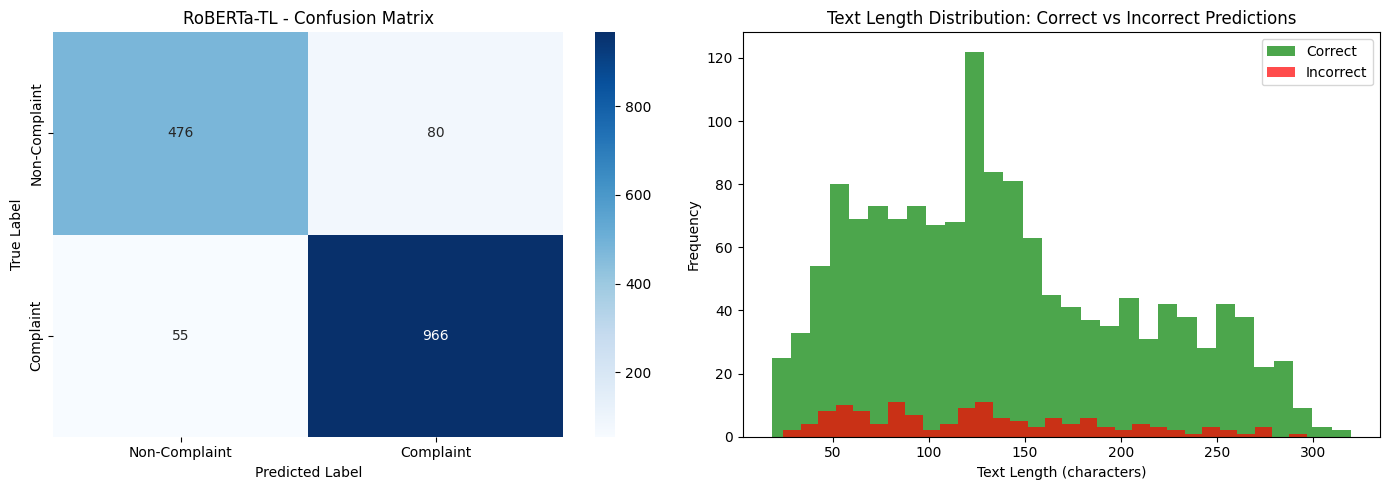


CLASSIFICATION REPORT (RoBERTa-TL)
               precision    recall  f1-score   support

Non-Complaint       0.90      0.86      0.88       556
    Complaint       0.92      0.95      0.93      1021

     accuracy                           0.91      1577
    macro avg       0.91      0.90      0.91      1577
 weighted avg       0.91      0.91      0.91      1577



In [14]:
print("="*60)
print("ERROR ANALYSIS")
print("="*60)

# Determine best model based on F1-score
best_model_idx = comparison_df['f1'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
print(f"\nAnalyzing errors from best model: {best_model_name}")

# Get predictions from best model
if 'XLM' in best_model_name:
    best_predictions = xlm_test_pred
elif 'RoBERTa-TL' in best_model_name:
    best_predictions = tl_test_pred
elif 'Tuned' in best_model_name:
    best_predictions = test_pred_tuned
else:
    best_predictions = test_pred_baseline

# Create error analysis DataFrame
test_analysis_df = test_df.copy().reset_index(drop=True)
test_analysis_df['predicted'] = best_predictions
test_analysis_df['correct'] = test_analysis_df['label'] == test_analysis_df['predicted']

# Identify misclassified samples
errors_df = test_analysis_df[~test_analysis_df['correct']].copy()

print(f"\nTotal test samples: {len(test_analysis_df)}")
print(f"Correctly classified: {test_analysis_df['correct'].sum()}")
print(f"Misclassified: {len(errors_df)} ({len(errors_df)/len(test_analysis_df)*100:.1f}%)")

# Breakdown by error type
false_positives = errors_df[(errors_df['label'] == 0) & (errors_df['predicted'] == 1)]
false_negatives = errors_df[(errors_df['label'] == 1) & (errors_df['predicted'] == 0)]

print(f"\nError Breakdown:")
print(f"  False Positives (predicted Complaint, actually Non-Complaint): {len(false_positives)}")
print(f"  False Negatives (predicted Non-Complaint, actually Complaint): {len(false_negatives)}")

# Display sample misclassified examples
print("\n" + "="*60)
print("SAMPLE FALSE POSITIVES (Predicted: Complaint, True: Non-Complaint)")
print("="*60)
if len(false_positives) > 0:
    for idx, row in false_positives.head(5).iterrows():
        print(f"\nText: {row['text'][:200]}..." if len(row['text']) > 200 else f"\nText: {row['text']}")
        print(f"True Label: Non-Complaint (0) | Predicted: Complaint (1)")
        print("-" * 50)
else:
    print("No false positives found.")

print("\n" + "="*60)
print("SAMPLE FALSE NEGATIVES (Predicted: Non-Complaint, True: Complaint)")
print("="*60)
if len(false_negatives) > 0:
    for idx, row in false_negatives.head(5).iterrows():
        print(f"\nText: {row['text'][:200]}..." if len(row['text']) > 200 else f"\nText: {row['text']}")
        print(f"True Label: Complaint (1) | Predicted: Non-Complaint (0)")
        print("-" * 50)
else:
    print("No false negatives found.")

# Error analysis by text length
print("\n" + "="*60)
print("ERROR ANALYSIS BY TEXT LENGTH")
print("="*60)
test_analysis_df['text_length'] = test_analysis_df['text'].str.len()
errors_df['text_length'] = errors_df['text'].str.len()

print(f"\nAverage text length (all samples): {test_analysis_df['text_length'].mean():.1f}")
print(f"Average text length (errors): {errors_df['text_length'].mean():.1f}")

# Visualize error distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Confusion matrix for best model
cm_best = confusion_matrix(test_analysis_df['label'], test_analysis_df['predicted'])
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Non-Complaint', 'Complaint'],
            yticklabels=['Non-Complaint', 'Complaint'])
axes[0].set_title(f'{best_model_name} - Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Plot 2: Text length distribution for correct vs incorrect
correct_lengths = test_analysis_df[test_analysis_df['correct']]['text_length']
incorrect_lengths = test_analysis_df[~test_analysis_df['correct']]['text_length']

axes[1].hist(correct_lengths, bins=30, alpha=0.7, label='Correct', color='green')
axes[1].hist(incorrect_lengths, bins=30, alpha=0.7, label='Incorrect', color='red')
axes[1].set_xlabel('Text Length (characters)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Text Length Distribution: Correct vs Incorrect Predictions')
axes[1].legend()

plt.tight_layout()
plt.show()

# Classification report for best model
print("\n" + "="*60)
print(f"CLASSIFICATION REPORT ({best_model_name})")
print("="*60)
print(classification_report(test_analysis_df['label'], test_analysis_df['predicted'],
                            target_names=['Non-Complaint', 'Complaint']))

## 15. Test on New Taglish Samples
Test the models on real-world examples

In [15]:
# New test samples
new_samples = [
    "Sobrang bagal ng delivery, 3 weeks na wala pa rin!",
    "Super satisfied with my purchase, highly recommended!",
    "Wrong item delivered, gusto ko ng refund ASAP",
    "Ang ganda ng quality, worth it talaga",
    "Scam ba ito? Hindi tugma sa description",
    "Fast shipping and excellent packaging",
    "Sira yung product, disappointed ako",
    "Great seller, very accommodating and responsive",
    "Hindi sulit yung price, overpriced masyado",
    "Perfect! Exactly what I ordered, salamat!"
]

print("="*60)
print("TESTING ON NEW TAGLISH SAMPLES")
print("="*60)

print("\nTest Samples:")
for i, sample in enumerate(new_samples, 1):
    print(f"{i:2d}. {sample}")

# Function to predict with transformer
def predict_with_transformer(texts, model, tokenizer):
    """Predict labels for new texts"""
    model.eval()
    predictions = []

    for text in texts:
        # Clean text
        cleaned = clean_taglish_text(text)

        # Tokenize
        inputs = tokenizer(
            cleaned,
            return_tensors='pt',
            truncation=True,
            padding=True,
            max_length=256
        ).to(device)

        # Predict
        with torch.no_grad():
            outputs = model(**inputs)
            pred = torch.argmax(outputs.logits, dim=1).item()

        predictions.append(pred)

    return predictions

# Predict with XLM-RoBERTa
xlm_predictions = predict_with_transformer(new_samples, xlm_model, xlm_tokenizer)

# Predict with RoBERTa-TL
tl_predictions = predict_with_transformer(new_samples, tl_model, tl_tokenizer)

# Predict with baseline
cleaned_samples = [clean_taglish_text(s) for s in new_samples]
baseline_vec = tfidf_vectorizer.transform(cleaned_samples)
baseline_predictions = best_lr.predict(baseline_vec)

# Display results
print("\n" + "="*60)
print("PREDICTIONS")
print("="*60)
print(f"{'Sample':<50} {'Baseline':^10} {'XLM-R':^10} {'RoBERTa-TL':^10}")
print("-" * 80)

label_map = {0: 'Non-Comp', 1: 'Complaint'}
for i, sample in enumerate(new_samples):
    short_sample = sample[:45] + "..." if len(sample) > 45 else sample
    print(f"{short_sample:<50} {label_map[baseline_predictions[i]]:^10} {label_map[xlm_predictions[i]]:^10} {label_map[tl_predictions[i]]:^10}")

TESTING ON NEW TAGLISH SAMPLES

Test Samples:
 1. Sobrang bagal ng delivery, 3 weeks na wala pa rin!
 2. Super satisfied with my purchase, highly recommended!
 3. Wrong item delivered, gusto ko ng refund ASAP
 4. Ang ganda ng quality, worth it talaga
 5. Scam ba ito? Hindi tugma sa description
 6. Fast shipping and excellent packaging
 7. Sira yung product, disappointed ako
 8. Great seller, very accommodating and responsive
 9. Hindi sulit yung price, overpriced masyado
10. Perfect! Exactly what I ordered, salamat!

PREDICTIONS
Sample                                              Baseline    XLM-R    RoBERTa-TL
--------------------------------------------------------------------------------
Sobrang bagal ng delivery, 3 weeks na wala pa...   Complaint  Complaint  Complaint 
Super satisfied with my purchase, highly reco...    Non-Comp   Non-Comp   Non-Comp 
Wrong item delivered, gusto ko ng refund ASAP      Complaint  Complaint  Complaint 
Ang ganda ng quality, worth it talaga           

## 16. Save Models and Results

In [16]:
# Save comparison results
comparison_df.to_csv('model_comparison_results.csv', index=False)
print("Results saved to 'model_comparison_results.csv'")

# Save error analysis
errors_df.to_csv('error_analysis.csv', index=False)
print("Error analysis saved to 'error_analysis.csv'")

# Save best model
best_model_name = comparison_df.loc[comparison_df['f1'].idxmax(), 'Model']
print(f"\nBest performing model: {best_model_name}")

# Save the best transformer model
if 'XLM' in best_model_name:
    xlm_trainer.save_model('./best_model')
    xlm_tokenizer.save_pretrained('./best_model')
elif 'RoBERTa-TL' in best_model_name:
    tl_trainer.save_model('./best_model')
    tl_tokenizer.save_pretrained('./best_model')

print(f"Best model saved to './best_model'")

# Save hyperparameter tuning results
tuning_results = pd.DataFrame(random_search.cv_results_)
tuning_results.to_csv('hyperparameter_tuning_results.csv', index=False)
print("Hyperparameter tuning results saved to 'hyperparameter_tuning_results.csv'")

Results saved to 'model_comparison_results.csv'
Error analysis saved to 'error_analysis.csv'

Best performing model: RoBERTa-TL
Best model saved to './best_model'
Hyperparameter tuning results saved to 'hyperparameter_tuning_results.csv'
